In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import folium
import geopandas as gpd

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from matplotlib import font_manager
font_manager.fontManager.addfont("./fonts/times.ttf")

MIN_LAT = 22.5311
MAX_LAT = 22.5517
MIN_LNG = 114.0439
MAX_LNG = 114.0633

%pwd

'/home/cseadmin/dz/TrafficFlowModel/scripts'

In [2]:
taxi_data_path = os.walk("../data/taxi")
all_files = []
for root,ds,fs in taxi_data_path:
    days = []
    for f in fs:
        full_path = os.path.join(root, f)
        days.append(full_path)
    if len(days)==0:
        continue
    all_files.append(days)
    
all_files.sort()
for day in all_files:
    day.sort()
all_files[:2]

[['../data/taxi/202006/2020-06-01/2020-06-01_0',
  '../data/taxi/202006/2020-06-01/2020-06-01_1',
  '../data/taxi/202006/2020-06-01/2020-06-01_2',
  '../data/taxi/202006/2020-06-01/2020-06-01_3',
  '../data/taxi/202006/2020-06-01/2020-06-01_4',
  '../data/taxi/202006/2020-06-01/2020-06-01_5',
  '../data/taxi/202006/2020-06-01/2020-06-01_6',
  '../data/taxi/202006/2020-06-01/2020-06-01_7',
  '../data/taxi/202006/2020-06-01/2020-06-01_8',
  '../data/taxi/202006/2020-06-01/2020-06-01_9'],
 ['../data/taxi/202006/2020-06-02/2020-06-02_0',
  '../data/taxi/202006/2020-06-02/2020-06-02_1',
  '../data/taxi/202006/2020-06-02/2020-06-02_2',
  '../data/taxi/202006/2020-06-02/2020-06-02_3',
  '../data/taxi/202006/2020-06-02/2020-06-02_4',
  '../data/taxi/202006/2020-06-02/2020-06-02_5',
  '../data/taxi/202006/2020-06-02/2020-06-02_6',
  '../data/taxi/202006/2020-06-02/2020-06-02_7',
  '../data/taxi/202006/2020-06-02/2020-06-02_8',
  '../data/taxi/202006/2020-06-02/2020-06-02_9']]

In [3]:
names = [
    "sys_time", "license_number", "lng", "lat", "gps_time", "EMPTY1", "speed",
    "direction", "car_status", "alarm_status", "EMPTY2", "EMPTY3",
    "license_color", "recorder_speed", "mileage", "height", "EMPTY4"
]

file_0601=all_files[1]

df_0601=pd.DataFrame()
for taxi_file in file_0601:
    df_0601=df_0601.append(pd.read_csv(taxi_file, names=names)[["license_number", "gps_time", "lat", "lng", "speed"]])

print(len(df_0601))
df_0601

97453725


,license_number,gps_time,lat,lng,speed
0,粤BD77165,2020-06-01 23:59:49,22.610820,113.920950,61
1,粤B7ZY30,2000-01-01 00:00:00,0.000000,0.000000,0
2,粤BD02973,2020-06-01 23:59:50,22.726140,114.265140,0
3,粤B0NC67,2000-01-01 00:00:00,0.000000,0.000000,0
4,粤BDR7746,2020-06-01 23:59:48,22.569310,114.099100,58
...,...,...,...,...,...
7453720,粤BDA1040,2020-06-02 23:59:51,22.556341,113.980740,0
7453721,粤BV2N51,2000-01-01 00:00:00,0.000000,0.000000,0
7453722,粤BD98097,2020-06-02 23:59:48,22.617779,113.934586,65
7453723,粤BV1P31,2000-01-01 00:00:00,0.000000,0.000000,0


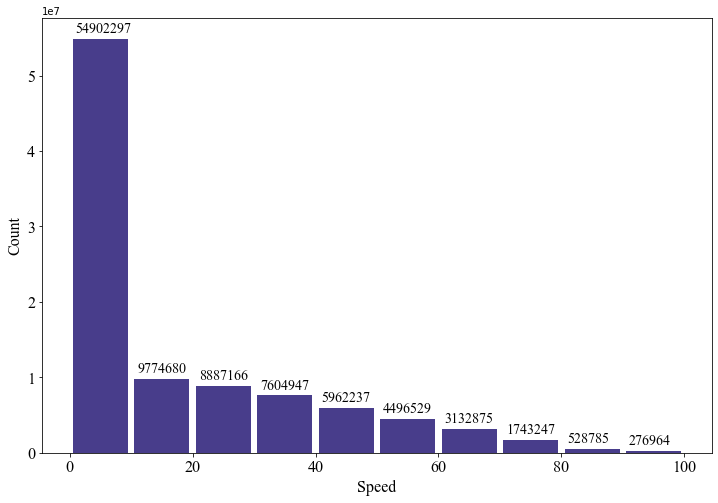

In [4]:
plt.figure(figsize=(12, 8))
plt.yticks(fontproperties = "Times New Roman", size = 16)
plt.xticks(fontproperties = "Times New Roman", size = 16)
plt.xlabel("Speed", fontdict={"family" : "Times New Roman", "size": 16})
plt.ylabel("Count", fontdict={"family" : "Times New Roman", "size": 16})
density, bins, _=plt.hist(df_0601.speed, bins=None, range=(0, 100), histtype="bar", rwidth=0.9, color="darkslateblue")
count, _ = np.histogram(df_0601.speed, bins)
for x, y, num in zip(bins, density, count):
    if num != 0:
        plt.text(x+1, y+0.8e6, num, fontsize=14, fontproperties = "Times New Roman") # x,y,str
plt.savefig("./images/speed_hist_before.png", dpi=300, bbox_inches="tight")
plt.show();

In [5]:
SZ_MINLON = 113.751647
SZ_MAXLON = 114.622924
SZ_MINLAT = 22.400047
SZ_MAXLAT = 22.855425

df_0601_clean=df_0601.drop_duplicates()
df_0601_clean=df_0601_clean.loc[(df_0601_clean["lat"]>=SZ_MINLAT) & (df_0601_clean["lat"]<=SZ_MAXLAT) &
                    (df_0601_clean["lng"]>=SZ_MINLON) & (df_0601_clean["lng"]<=SZ_MAXLON) &
                    (df_0601_clean["gps_time"]>="2020-06-01") & (df_0601_clean["gps_time"]<"2020-06-02") &
                    (df_0601_clean["speed"]<150) & (df_0601_clean["speed"]>0)]

df_0601_clean

,license_number,gps_time,lat,lng,speed
0,粤BD77165,2020-06-01 23:59:49,22.610820,113.92095,61
4,粤BDR7746,2020-06-01 23:59:48,22.569310,114.09910,58
6,粤BDG2918,2020-06-01 23:59:49,22.570156,113.92883,66
8,粤BD47906,2020-06-01 23:59:51,22.583370,113.86624,18
10,粤BA31863,2020-06-01 23:59:48,22.547894,114.12541,39
...,...,...,...,...,...
7428428,粤BDD0757,2020-06-01 13:00:17,22.713800,114.31099,16
7428432,粤BDD0757,2020-06-01 13:00:22,22.713871,114.31091,9
7428436,粤BDD0757,2020-06-01 13:00:42,22.712784,114.31088,33
7440834,粤BDD0757,2020-06-01 13:01:51,22.711248,114.30961,22


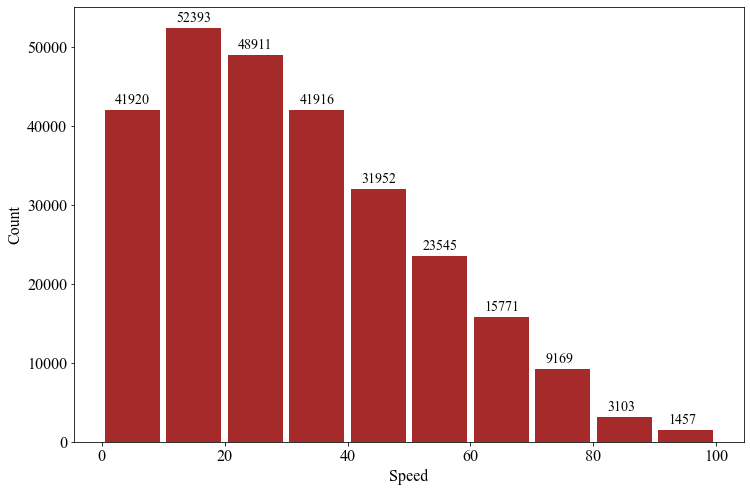

In [6]:
plt.figure(figsize=(12, 8))
plt.yticks(fontproperties = "Times New Roman", size = 16)
plt.xticks(fontproperties = "Times New Roman", size = 16)
plt.xlabel("Speed", fontdict={"family" : "Times New Roman", "size": 16})
plt.ylabel("Count", fontdict={"family" : "Times New Roman", "size": 16})
density, bins, _=plt.hist(df_0601_clean.speed, bins=None, range=(0, 100), histtype="bar", rwidth=0.9, color="brown")
count, _ = np.histogram(df_0601_clean.speed, bins)
for x, y, num in zip(bins, density, count):
    if num != 0:
        plt.text(x+2.2, y+800, num, fontsize=14, fontproperties = "Times New Roman") # x,y,str
plt.savefig("./images/speed_hist_after.png", dpi=300, bbox_inches="tight")
plt.show();

---

In [12]:
# map=folium.Map(location=[22.565050, 114.045616], 
#                zoom_start=12, 
#                tiles='OpenStreetMap'
#                )
# n=10
# file_path="../data/taxi_after_proc/merged/"

# count=0
# for taxi_file in os.listdir(file_path):
#     if os.path.getsize(os.path.join(file_path, taxi_file))<100:
#         continue
    
#     df_taxi=pd.read_csv(os.path.join(file_path, taxi_file))
#     gps_list=df_taxi[["lat", "lng"]].values.tolist()
    
#     for gps in gps_list:
#         trash=folium.Circle(gps, radius=10, weight=5, color="blue").add_to(map)

#     count+=1
#     if count>n:
#         break

# trash=folium.Rectangle([(MIN_LAT, MIN_LNG), (MAX_LAT, MAX_LNG)], color="red", weight=5).add_to(map)
# map

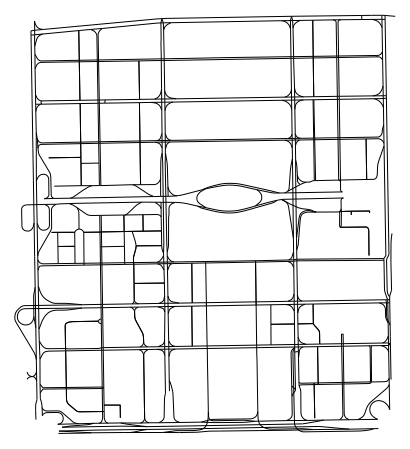

(<Figure size 864x576 with 1 Axes>, <AxesSubplot:>)

{'n': 532,
 'm': 906,
 'k_avg': 3.406015037593985,
 'edge_length_total': 97780.85099999986,
 'edge_length_avg': 107.92588410596011,
 'streets_per_node_avg': 3.2857142857142856,
 'streets_per_node_counts': {0: 0, 1: 10, 2: 0, 3: 350, 4: 172},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.018796992481203006,
  2: 0.0,
  3: 0.6578947368421053,
  4: 0.3233082706766917},
 'intersection_count': 522,
 'street_length_total': 90567.6929999999,
 'street_segment_count': 843,
 'street_length_avg': 107.43498576512444,
 'circuity_avg': 1.0334599830309064,
 'self_loop_proportion': 0.0}

In [35]:
futian_graph_drive=ox.graph_from_bbox(MIN_LAT, MAX_LAT, MIN_LNG, MAX_LNG, network_type="drive")

ox.plot_graph(futian_graph_drive, figsize=(12, 8), node_size=0, node_alpha=0.8, bgcolor="white", node_color="black", edge_color="black", show=True, save=True, filepath="./images/graph_before.png", dpi=300)
ox.basic_stats(futian_graph_drive)

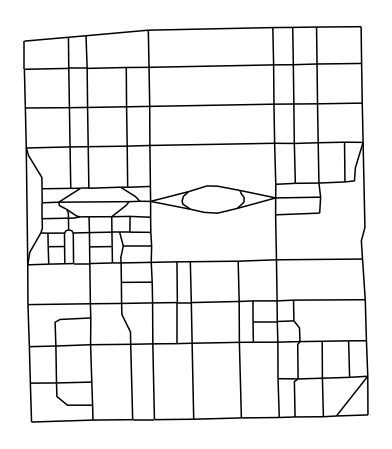

In [45]:
gdf = gpd.read_file("../data/sz_taxi_202006/gis/shenzhen.shp")
gdf.drop(columns="id", inplace=True)
gdf["fid"]=range(len(gdf))

ax=gdf.plot(color="black", figsize=(12, 8))
ax.set_axis_off()
ax.plot()
plt.savefig("./images/graph_after.png", dpi=300)
plt.show();

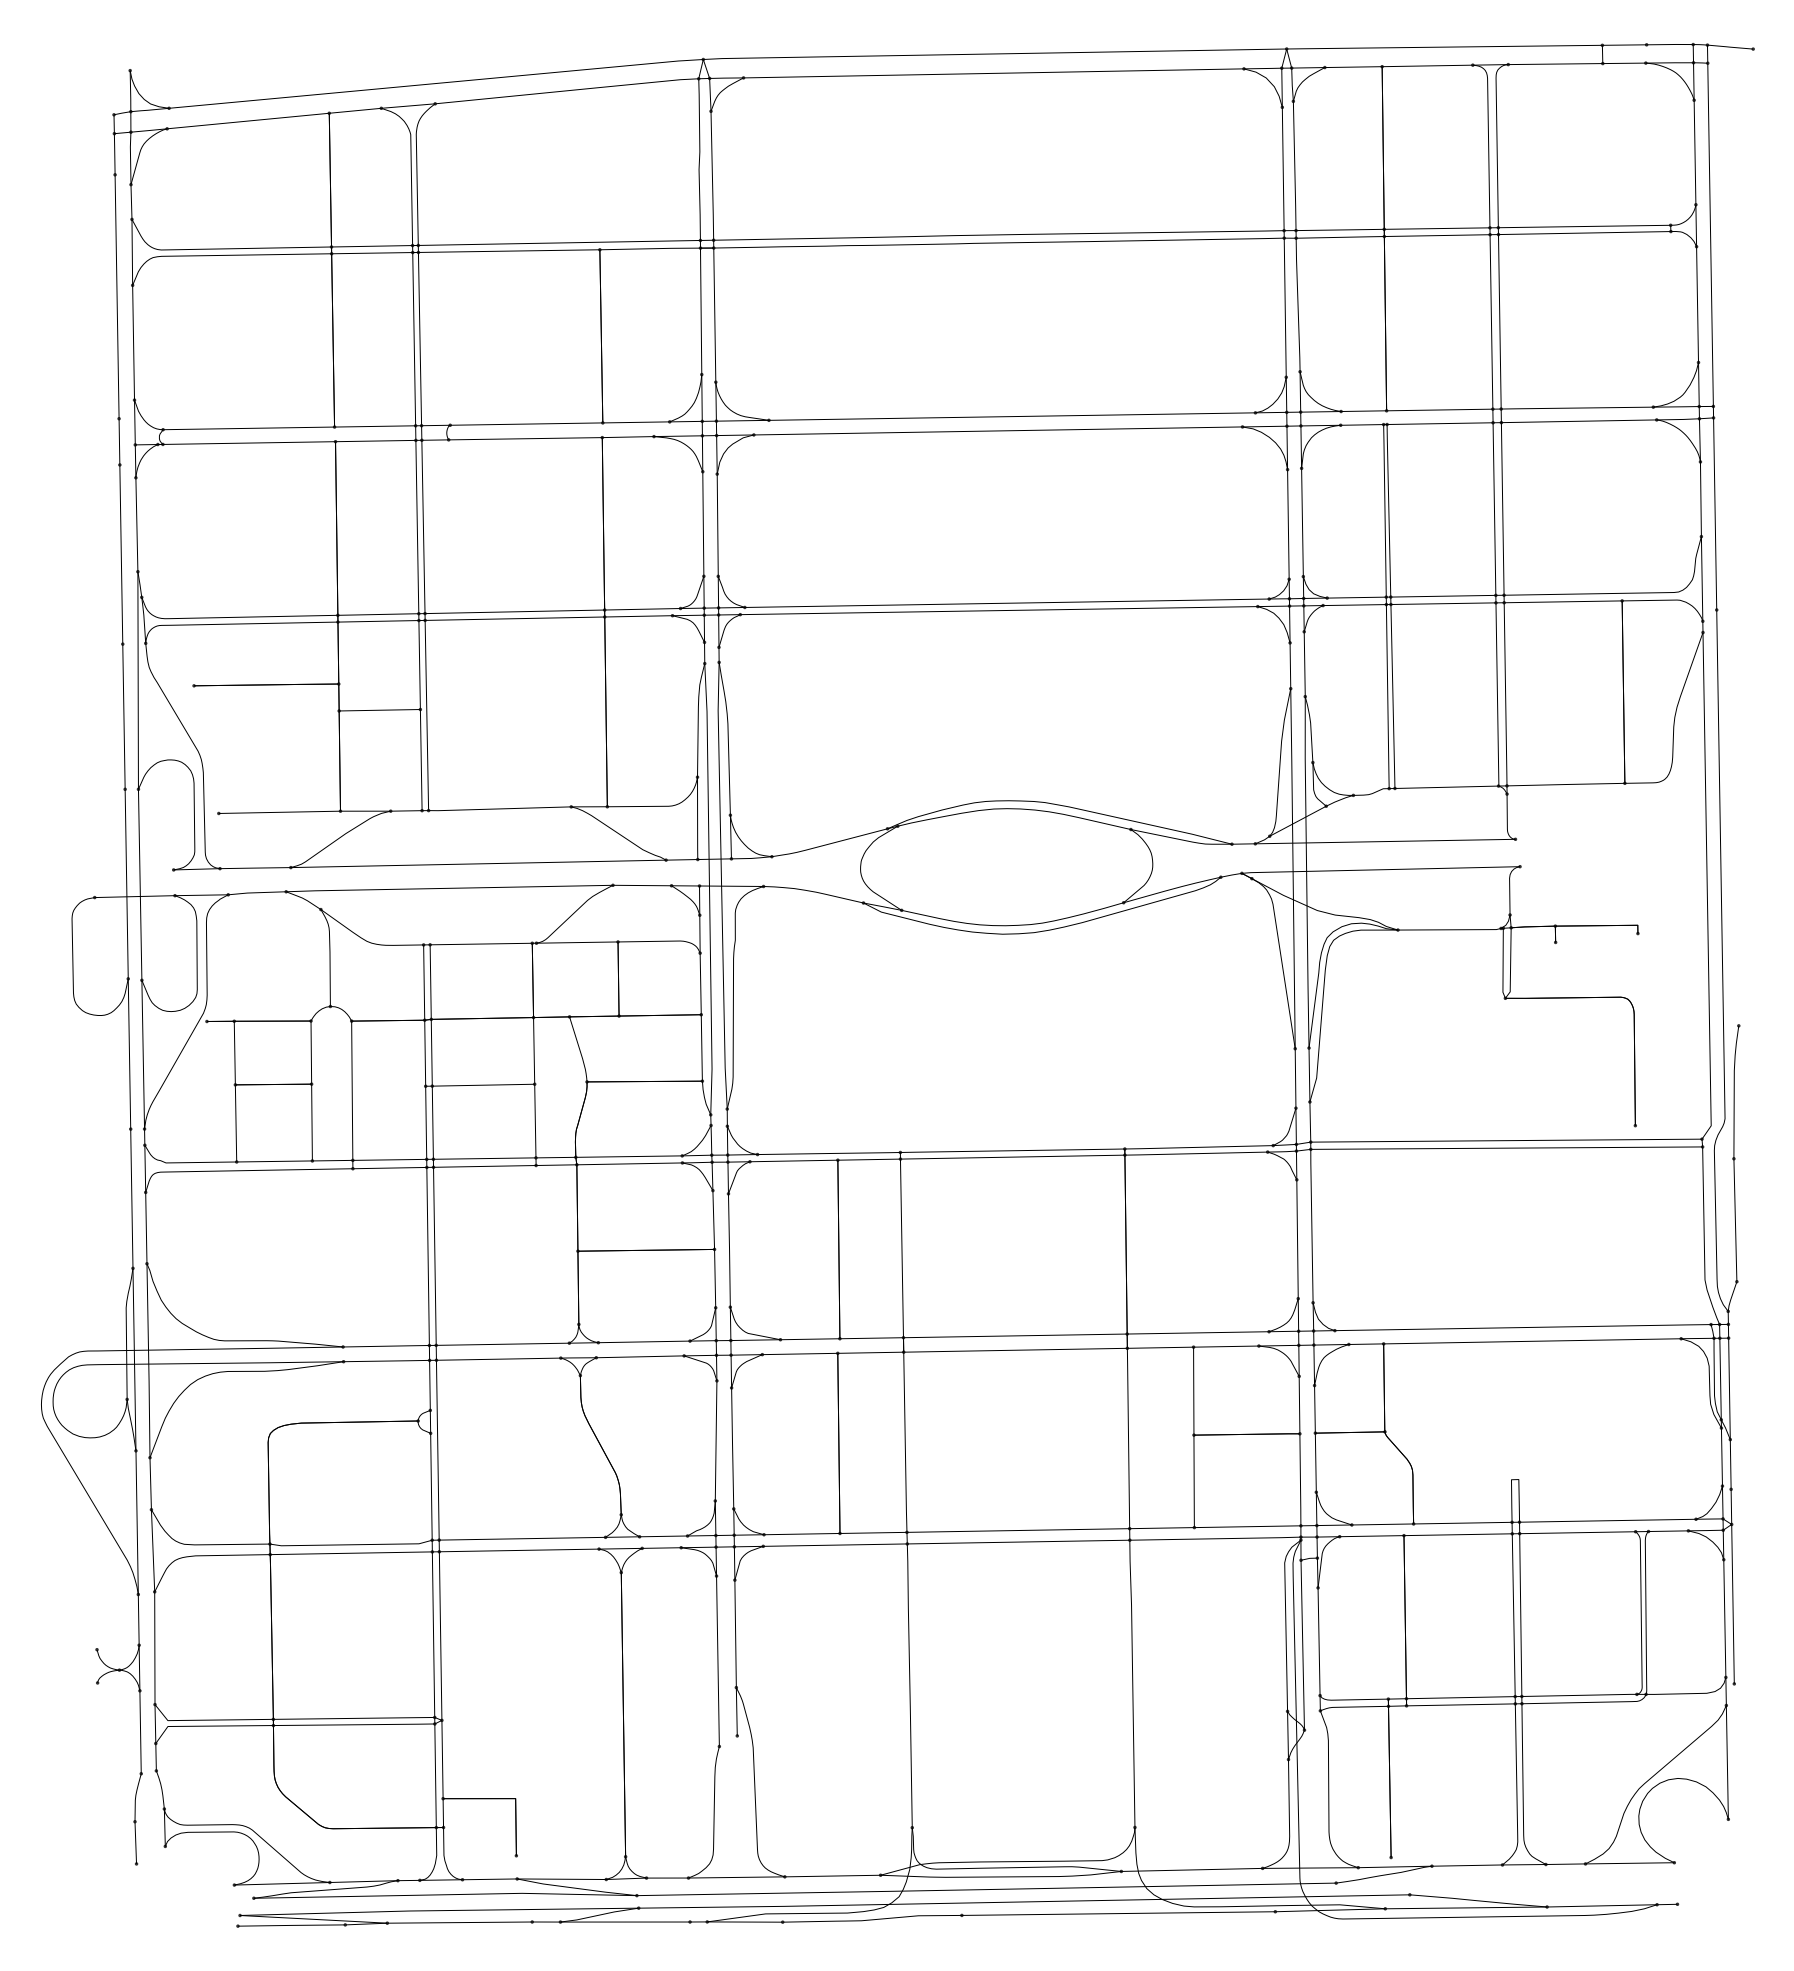

(<Figure size 3456x2592 with 1 Axes>, <AxesSubplot:>)

{'n': 532,
 'm': 906,
 'k_avg': 3.406015037593985,
 'edge_length_total': 97780.85099999986,
 'edge_length_avg': 107.92588410596011,
 'streets_per_node_avg': 3.2857142857142856,
 'streets_per_node_counts': {0: 0, 1: 10, 2: 0, 3: 350, 4: 172},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.018796992481203006,
  2: 0.0,
  3: 0.6578947368421053,
  4: 0.3233082706766917},
 'intersection_count': 522,
 'street_length_total': 90567.6929999999,
 'street_segment_count': 843,
 'street_length_avg': 107.43498576512444,
 'circuity_avg': 1.0334599830309064,
 'self_loop_proportion': 0.0}

In [5]:
futian_graph_drive=ox.graph_from_bbox(MIN_LAT, MAX_LAT, MIN_LNG, MAX_LNG, network_type="drive")

ox.plot_graph(futian_graph_drive, figsize=(48, 36), node_size=12, node_alpha=0.8, bgcolor="white", node_color="black", edge_color="black", show=True)
ox.basic_stats(futian_graph_drive)

---

In [19]:
embed_dim_list = [16, 32, 64, 128]
hidden_dim_list = [32, 64, 128, 256]
batch_size_list = [64, 128, 256, 512]
lr_list = [0.001, 0.0001]

In [20]:
# embed_dim=64
hidden_dim=256
batch_size=256
lr=0.0001

acc_embed_dim_list=[]
for embed_dim in embed_dim_list:
    with open(os.path.join("../model/log/", f"lstm_ed{embed_dim}_hd{hidden_dim}_bs{batch_size}_lr{lr}.log")) as f:
        acc=f.readlines()[-1].split(" ")[-2]
        acc=float(acc)
        
        acc_embed_dim_list.append(acc)

acc_embed_dim_list

[0.71838, 0.72825, 0.73012, 0.7331]

In [21]:
# embed_dim=16
# # hidden_dim=256
# batch_size=256
# lr=0.0001

# acc_hidden_dim_list=[]
# for hidden_dim in hidden_dim_list:
#     with open(os.path.join("../model/log/", f"lstm_ed{embed_dim}_hd{hidden_dim}_bs{batch_size}_lr{lr}.log")) as f:
#         acc=f.readlines()[-1].split(" ")[-2]
#         acc=float(acc)
        
#         acc_hidden_dim_list.append(acc)

# acc_hidden_dim_list

In [22]:
# embed_dim=32
# hidden_dim=256
batch_size=256
lr=0.0001

acc_hidden_dim_list=[]
for embed_dim, hidden_dim in [(16, 32), (32, 64), (64, 128), (64, 256)]:
    with open(os.path.join("../model/log/", f"lstm_ed{embed_dim}_hd{hidden_dim}_bs{batch_size}_lr{lr}.log")) as f:
        acc=f.readlines()[-1].split(" ")[-2]
        acc=float(acc)
        
        acc_hidden_dim_list.append(acc)

acc_hidden_dim_list

[0.71208, 0.72648, 0.72891, 0.73012]

In [23]:
embed_dim=64
hidden_dim=256
# batch_size=256
lr=0.0001

acc_batch_size_list=[]
for batch_size in batch_size_list:
    with open(os.path.join("../model/log/", f"lstm_ed{embed_dim}_hd{hidden_dim}_bs{batch_size}_lr{lr}.log")) as f:
        acc=f.readlines()[-1].split(" ")[-2]
        acc=float(acc)
        
        acc_batch_size_list.append(acc)

acc_batch_size_list

[0.73185, 0.73303, 0.73012, 0.73349]

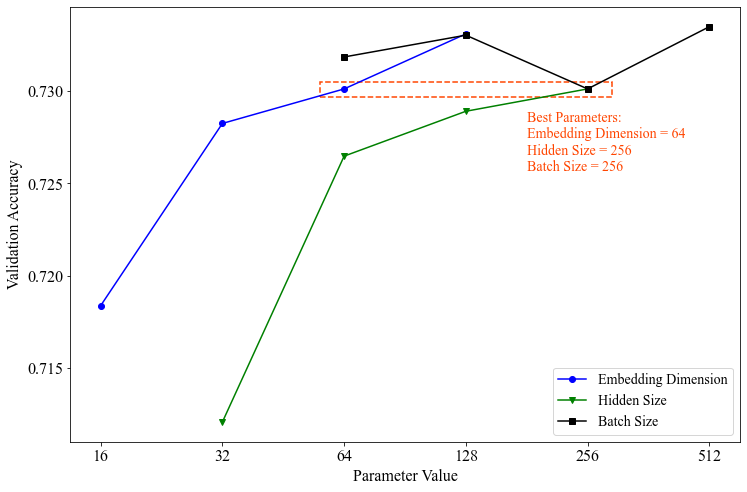

In [24]:
plt.figure(figsize=(12, 8))
plt.yticks(fontproperties = "Times New Roman", size = 16)
plt.xticks(fontproperties = "Times New Roman", size = 16)
plt.xlabel("Parameter Value", fontdict={"family" : "Times New Roman", "size": 16})
plt.ylabel("Validation Accuracy", fontdict={"family" : "Times New Roman", "size": 16})
plt.plot(list(map(str, embed_dim_list)), acc_embed_dim_list, "bo-", label="Embedding Dimension")
plt.plot(list(map(str, hidden_dim_list)), acc_hidden_dim_list, "gv-", label="Hidden Size")
plt.plot(list(map(str, batch_size_list)), acc_batch_size_list, "ks-", label="Batch Size")
plt.gca().add_patch(plt.Rectangle((1.8, 0.7297), 2.4, 0.0008, color="orangered", fill=False, lw=1.5, ls="--"))
txt="Best Parameters:\nEmbedding Dimension = 64\nHidden Size = 256\nBatch Size = 256"
plt.text(3.5, 0.7257, txt, fontsize=14, fontproperties = "Times New Roman", color="orangered")
plt.legend(prop={"family" : "Times New Roman", "size": 14}, loc="lower right")
plt.savefig("./images/next-hop_param.png", dpi=300, bbox_inches="tight")
plt.show();

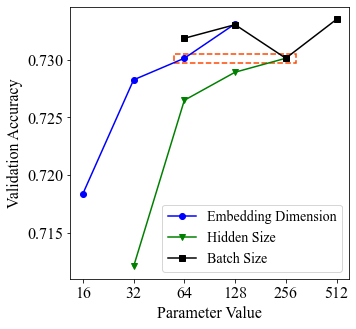

In [37]:
plt.figure(figsize=(5, 5))
plt.yticks(fontproperties = "Times New Roman", size = 16)
plt.xticks(fontproperties = "Times New Roman", size = 16)
plt.xlabel("Parameter Value", fontdict={"family" : "Times New Roman", "size": 16})
plt.ylabel("Validation Accuracy", fontdict={"family" : "Times New Roman", "size": 16})
plt.plot(list(map(str, embed_dim_list)), acc_embed_dim_list, "bo-", label="Embedding Dimension")
plt.plot(list(map(str, hidden_dim_list)), acc_hidden_dim_list, "gv-", label="Hidden Size")
plt.plot(list(map(str, batch_size_list)), acc_batch_size_list, "ks-", label="Batch Size")
plt.gca().add_patch(plt.Rectangle((1.8, 0.7297), 2.4, 0.0008, color="orangered", fill=False, lw=1.5, ls="--"))
# txt="Best Parameters:\nEmbedding Dimension = 64\nHidden Size = 256\nBatch Size = 256"
# plt.text(3.5, 0.7257, txt, fontsize=14, fontproperties = "Times New Roman", color="orangered")
plt.legend(prop={"family" : "Times New Roman", "size": 14}, loc="lower right")
plt.savefig("./images/next-hop_param2.png", dpi=300, bbox_inches="tight")
plt.show();

In [10]:
k_list=list(map(str, range(2, 31)))

flow_step3_list=[]
flow_step6_list=[]
flow_step12_list=[]

for k in k_list:
    with open(os.path.join("../../DL-Traff-Graph/log_flow_knn/3", f"STGCN3_{k}.log"), "r") as f:
        line=f.readlines()[-3]
        # mape=float(line.split(",")[-1].strip("\n"))
        # mae=float(line.split(",")[-2].strip("\n"))
        rmse=float(line.split(",")[-3].strip("\n"))
        
        flow_step3_list.append(rmse)
        
    with open(os.path.join("../../DL-Traff-Graph/log_flow_knn/6", f"STGCN6_{k}.log"), "r") as f:
        line=f.readlines()[-3]
        # mape=float(line.split(",")[-1].strip("\n"))
        # mae=float(line.split(",")[-2].strip("\n"))
        rmse=float(line.split(",")[-3].strip("\n"))
        
        flow_step6_list.append(rmse)
        
    with open(os.path.join("../../DL-Traff-Graph/log_flow_knn/12", f"STGCN12_{k}.log"), "r") as f:
        line=f.readlines()[-3]
        # mape=float(line.split(",")[-1].strip("\n"))
        # mae=float(line.split(",")[-2].strip("\n"))
        rmse=float(line.split(",")[-3].strip("\n"))
        
        flow_step12_list.append(rmse)

flow_step3_list[0]
flow_step6_list[0]
flow_step12_list[0]

4.4680528118

4.6269643106

4.9752523614

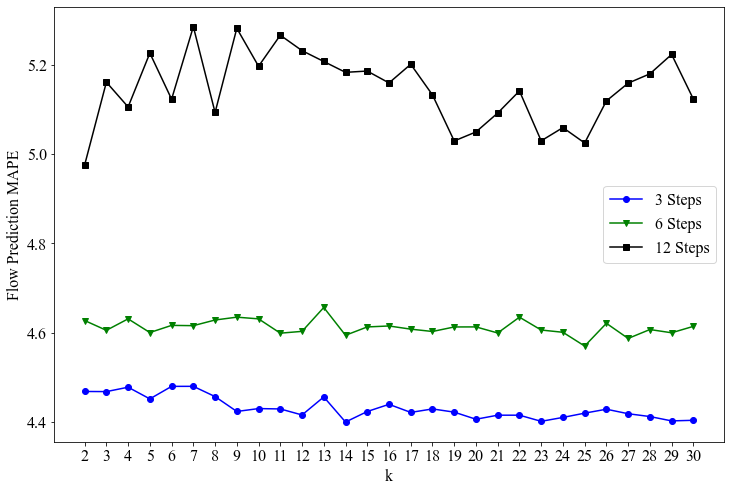

In [11]:
plt.figure(figsize=(12, 8))
plt.yticks(fontproperties = "Times New Roman", size = 16)
plt.xticks(fontproperties = "Times New Roman", size = 16)
plt.xlabel("k", fontdict={"family" : "Times New Roman", "size": 16})
plt.ylabel("Flow Prediction RMSE", fontdict={"family" : "Times New Roman", "size": 16})
plt.plot(k_list, flow_step3_list, "bo-", label="3 Steps")
plt.plot(k_list, flow_step6_list, "gv-", label="6 Steps")
plt.plot(k_list, flow_step12_list, "ks-", label="12 Steps")
plt.legend(prop={"family" : "Times New Roman", "size": 16}, loc="best")
plt.savefig("./images/k-flow.png", dpi=300, bbox_inches='tight')
plt.show();

In [15]:
k_list=list(map(str, range(2, 21)))

flow_step3_list=[]
flow_step6_list=[]
flow_step12_list=[]

for k in k_list:
    with open(os.path.join("../../DL-Traff-Graph/log_flow_knn/GWN", f"GWN_{k}.log"), "r") as f:
        lines=f.readlines()
        rmse12=float(lines[-2].split(",")[-3].strip("\n"))
        rmse6=float(lines[-8].split(",")[-3].strip("\n"))
        rmse3=float(lines[-11].split(",")[-3].strip("\n"))
        
        flow_step3_list.append(rmse3)
        flow_step6_list.append(rmse6)
        flow_step12_list.append(rmse12)
        
flow_step3_list[0]
flow_step6_list[0]
flow_step12_list[0]

4.5324550322

4.8160418596

5.4315484939

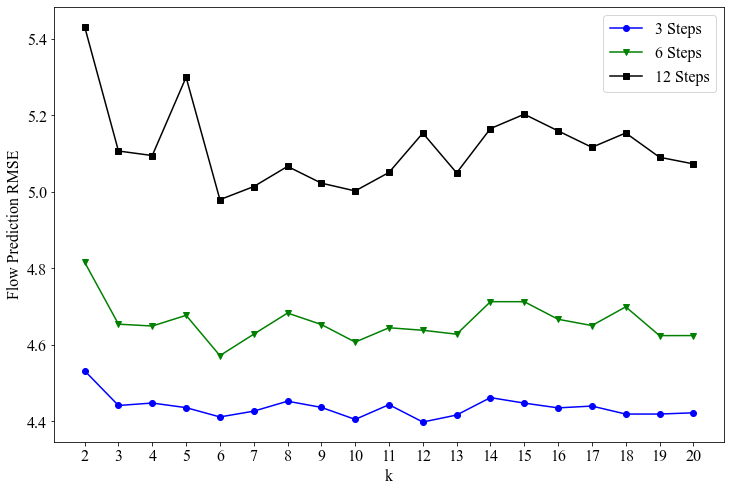

In [17]:
plt.figure(figsize=(12, 8))
plt.yticks(fontproperties = "Times New Roman", size = 16)
plt.xticks(fontproperties = "Times New Roman", size = 16)
plt.xlabel("k", fontdict={"family" : "Times New Roman", "size": 16})
plt.ylabel("Flow Prediction RMSE", fontdict={"family" : "Times New Roman", "size": 16})
plt.plot(k_list, flow_step3_list, "bo-", label="3 Steps")
plt.plot(k_list, flow_step6_list, "gv-", label="6 Steps")
plt.plot(k_list, flow_step12_list, "ks-", label="12 Steps")
plt.legend(prop={"family" : "Times New Roman", "size": 16}, loc="best")
plt.savefig("./images/k-flow.png", dpi=300, bbox_inches='tight')
plt.show();

In [16]:
speed_step3_list=[]
speed_step6_list=[]
speed_step12_list=[]

for k in k_list:
    with open(os.path.join("../../DL-Traff-Graph/log_speed_knn/3", f"STGCN3_{k}.log"), "r") as f:
        line=f.readlines()[-3]
        mape=float(line.split(",")[-1].strip("\n"))
        
        speed_step3_list.append(mape)
        
    with open(os.path.join("../../DL-Traff-Graph/log_speed_knn/6", f"STGCN6_{k}.log"), "r") as f:
        line=f.readlines()[-3]
        mape=float(line.split(",")[-1].strip("\n"))
        
        speed_step6_list.append(mape)
        
    with open(os.path.join("../../DL-Traff-Graph/log_speed_knn/12", f"STGCN12_{k}.log"), "r") as f:
        line=f.readlines()[-3]
        mape=float(line.split(",")[-1].strip("\n"))
        
        speed_step12_list.append(mape)

speed_step3_list[0]
speed_step6_list[0]
speed_step12_list[0]

23.7785044325

23.950744735

24.0358457569

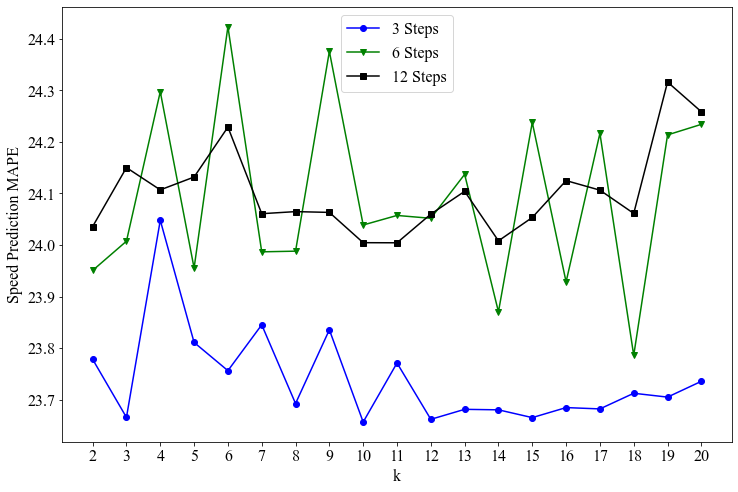

In [17]:
plt.figure(figsize=(12, 8))
plt.yticks(fontproperties = "Times New Roman", size = 16)
plt.xticks(fontproperties = "Times New Roman", size = 16)
plt.xlabel("k", fontdict={"family" : "Times New Roman", "size": 16})
plt.ylabel("Speed Prediction MAPE", fontdict={"family" : "Times New Roman", "size": 16})
plt.plot(k_list, speed_step3_list, "bo-", label="3 Steps")
plt.plot(k_list, speed_step6_list, "gv-", label="6 Steps")
plt.plot(k_list, speed_step12_list, "ks-", label="12 Steps")
plt.legend(prop={"family" : "Times New Roman", "size": 16}, loc="best")
plt.savefig("./images/k-speed.png", dpi=300, bbox_inches='tight')
plt.show();

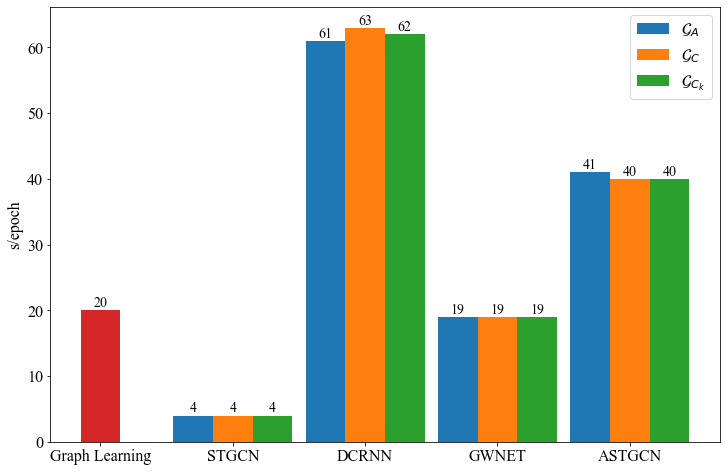

In [41]:
t_latent=20

t_STGCN_A=4
t_STGCN_Gc=4
t_STGCN_Gck=4

t_DCRNN_A=61
t_DCRNN_Gc=63
t_DCRNN_Gck=62

t_GWNET_A=19
t_GWNET_Gc=19
t_GWNET_Gck=19

t_ASTGCN_A=41
t_ASTGCN_Gc=40
t_ASTGCN_Gck=40

A_list=[t_STGCN_A, t_DCRNN_A, t_GWNET_A, t_ASTGCN_A]
Gc_list=[t_STGCN_Gc, t_DCRNN_Gc, t_GWNET_Gc, t_ASTGCN_Gc]
Gck_list=[t_STGCN_Gck, t_DCRNN_Gck, t_GWNET_Gck, t_ASTGCN_Gck]
labels=["Graph Learning", "STGCN", "DCRNN", "GWNET", "ASTGCN"]

def set_label(rects):
    for rect in rects:
        height = rect.get_height() # 获取⾼度
        plt.text(x = rect.get_x() + rect.get_width()/2, # ⽔平坐标
                 y = height + 0.5, # 竖直坐标
                 s = height, # ⽂本
                 ha = 'center', # ⽔平居中
                 fontsize=14, 
                 fontproperties = "Times New Roman")
        
        
x = np.arange(len(A_list))

plt.figure(figsize=(12, 8))
plt.yticks(fontproperties = "Times New Roman", size = 16)
plt.xticks(np.arange(-1, len(A_list)), labels, fontproperties = "Times New Roman", size = 16)
plt.ylabel("s/epoch", fontdict={"family" : "Times New Roman", "size": 16})

width=0.3
bar1=plt.bar(x-width, A_list, width)
bar2=plt.bar(x, Gc_list, width)
bar3=plt.bar(x+width, Gck_list, width)
bar4=plt.bar(-1, t_latent, width)
plt.legend([r"$\mathcal{G}_A$", r"$\mathcal{G}_C$", r"$\mathcal{G}_{C_k}$"], prop={"family" : "Times New Roman", "size": 16}, loc="best")
 
set_label(bar1)
set_label(bar2)
set_label(bar3)
set_label(bar4)

plt.savefig("./images/train_time.png", dpi=300, bbox_inches='tight')
plt.show();

In [2]:
w_list=list(map(str, range(2, 11)))

rmse_list=[]
mae_list=[]
mape_list=[]

for w in w_list:
    with open(os.path.join("../../DL-Traff-Graph/log_flow_w", f"GWN_w{w}.log"), "r") as f:
        line=f.readlines()[-14]
        rmse=float(line.split(",")[-3].strip("\n"))
        mae=float(line.split(",")[-2].strip("\n"))
        mape=float(line.split(",")[-1].strip("\n"))
        
        rmse_list.append(rmse)
        mae_list.append(mae)
        mape_list.append(mape)
        
rmse_list[0]
mae_list[0]
mape_list[0]

4.7940105507

3.656718611

34.2420548201

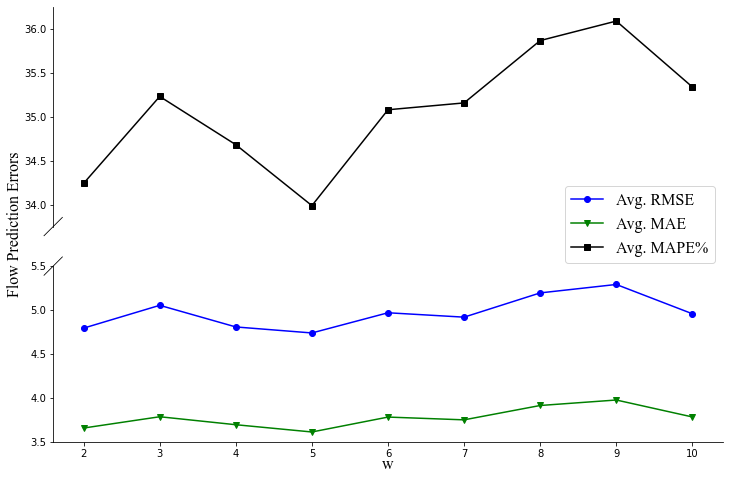

In [35]:
from brokenaxes import brokenaxes

plt.figure(figsize=(12, 8))
bax=brokenaxes(ylims=((3.5, 5.5), (33.75, 36.25)))
bax.set_xlabel("w", fontdict={"family" : "Times New Roman", "size": 16})
bax.set_ylabel("Flow Prediction Errors", fontdict={"family" : "Times New Roman", "size": 16})
bax.plot(w_list, rmse_list, "bo-", label="Avg. RMSE")
bax.plot(w_list, mae_list, "gv-", label="Avg. MAE")
bax.plot(w_list, mape_list, "ks-", label="Avg. MAPE%")
bax.legend(prop={"family" : "Times New Roman", "size": 16}, loc="center right")
# plt.savefig("./images/w-gwnet.png", dpi=300, bbox_inches='tight')
plt.show();

/tmp/ipykernel_32049/1516623645.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(["33.5", "34.0", "34.5", "35.0", "35.5", "36.0", "36.5"], fontdict={"family" : "Times New Roman", "size": 16})


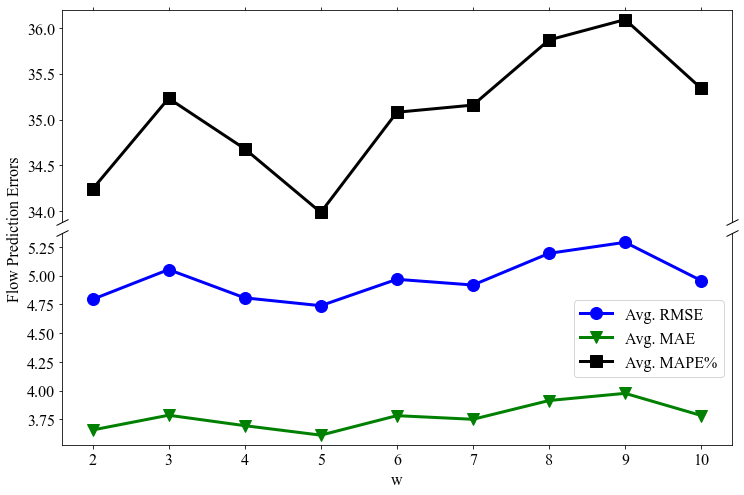

In [5]:
# If we were to simply plot pts, we'd lose most of the interesting
# details due to the outliers. So let's 'break' or 'cut-out' the y-axis
# into two portions - use the top (ax1) for the outliers, and the bottom
# (ax2) for the details of the majority of our data
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 8))
fig.subplots_adjust(hspace=0.05)  # adjust space between axes


# plot the same data on both axes
line1=ax2.plot(w_list, rmse_list, "bo-", linewidth=3, markersize=12, label="Avg. RMSE")
line2=ax2.plot(w_list, mae_list, "gv-", linewidth=3, markersize=12, label="Avg. MAE")
line3=ax1.plot(w_list, mape_list, "ks-", linewidth=3, markersize=12, label="Avg. MAPE%")

plt.xticks(fontproperties = "Times New Roman", size = 16)
plt.yticks(fontproperties = "Times New Roman", size = 16)
ax1.set_yticklabels(["33.5", "34.0", "34.5", "35.0", "35.5", "36.0", "36.5"], fontdict={"family" : "Times New Roman", "size": 16})

plt.xlabel("w", fontdict={"family" : "Times New Roman", "size": 16})
ax2.set_ylabel("Flow Prediction Errors", fontdict={"family" : "Times New Roman", "size": 16})
ax2.yaxis.set_label_coords(0.08, 0.5, transform=fig.transFigure)


# zoom-in / limit the view to different portions of the data
# ax1.set_ylim(33, 37)  # outliers only
# ax2.set_ylim(3, 5)  # most of the data


# hide the spines between ax and ax2
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

# Now, let's turn towards the cut-out slanted lines.
# We create line objects in axes coordinates, in which (0,0), (0,1),
# (1,0), and (1,1) are the four corners of the axes.
# The slanted lines themselves are markers at those locations, such that the
# lines keep their angle and position, independent of the axes size or scale
# Finally, we need to disable clipping.

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

lines = line1+line2+line3
labels = [l.get_label() for l in lines]
ax2.legend(lines, labels, prop={"family" : "Times New Roman", "size": 16}, loc="best")

plt.savefig("./images/w-gwnet.png", dpi=300, bbox_inches='tight')
plt.show();

In [6]:
k_list=list(map(str, range(2, 21)))

rmse_list=[]
mae_list=[]
mape_list=[]

for k in k_list:
    with open(os.path.join("../../DL-Traff-Graph/log_flow_knn/GWN", f"GWN_{k}.log"), "r") as f:
        line=f.readlines()[-14]
        rmse=float(line.split(",")[-3].strip("\n"))
        mae=float(line.split(",")[-2].strip("\n"))
        mape=float(line.split(",")[-1].strip("\n"))
        
        rmse_list.append(rmse)
        mae_list.append(mae)
        mape_list.append(mape)
        
rmse_list[0]
mae_list[0]
mape_list[0]

4.8931458657

3.7239080423

34.6865057945

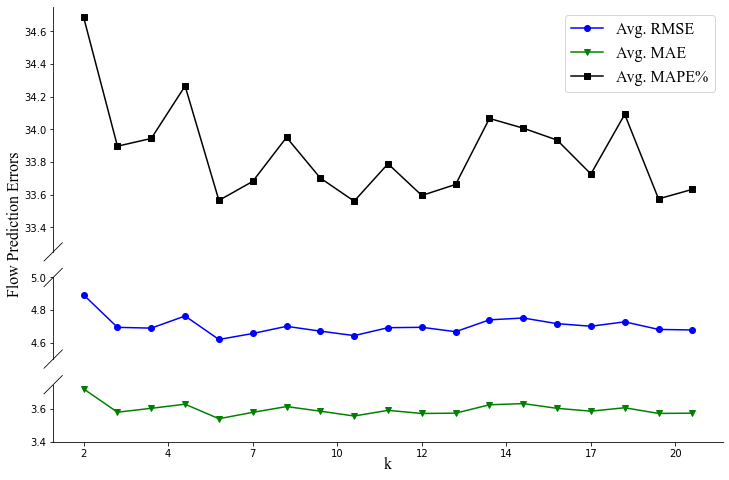

In [93]:
from brokenaxes import brokenaxes # 一坨屎这个库 x轴永远不对 滚

plt.figure(figsize=(12, 8))
bax=brokenaxes(ylims=((3.4, 3.75), (4.5, 5), (33.25, 34.75)))
# bax.big_ax.set_xticks(list(range(len(k_list))))
# bax.big_ax.set_xticklabels(k_list)
bax.set_xlabel("k", fontdict={"family" : "Times New Roman", "size": 16})
bax.set_ylabel("Flow Prediction Errors", fontdict={"family" : "Times New Roman", "size": 16})
bax.plot(k_list, rmse_list, "bo-", label="Avg. RMSE")
bax.plot(k_list, mae_list, "gv-", label="Avg. MAE")
bax.plot(k_list, mape_list, "ks-", label="Avg. MAPE%")
bax.legend(prop={"family" : "Times New Roman", "size": 16}, loc="best")
# plt.savefig("./images/w-gwnet.png", dpi=300, bbox_inches='tight')
plt.show();

/tmp/ipykernel_32049/4101986808.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(["33.4", "33.6", "33.8", "34.0", "34.2", "34.4", "34.6", "34.8"], fontdict={"family" : "Times New Roman", "size": 16})


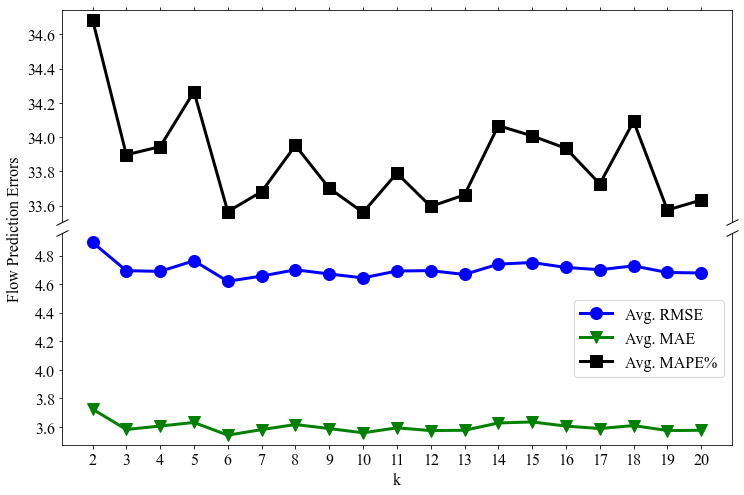

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 8))
fig.subplots_adjust(hspace=0.05)  # adjust space between axes

# plot the same data on both axes
line1=ax2.plot(k_list, rmse_list, "bo-", linewidth=3, markersize=12, label="Avg. RMSE")
line2=ax2.plot(k_list, mae_list, "gv-", linewidth=3, markersize=12, label="Avg. MAE")
line3=ax1.plot(k_list, mape_list, "ks-", linewidth=3, markersize=12, label="Avg. MAPE%")

plt.xticks(fontproperties = "Times New Roman", size = 16)
plt.yticks(fontproperties = "Times New Roman", size = 16)
ax1.set_yticklabels(["33.4", "33.6", "33.8", "34.0", "34.2", "34.4", "34.6", "34.8"], fontdict={"family" : "Times New Roman", "size": 16})

plt.xlabel("k", fontdict={"family" : "Times New Roman", "size": 16})
ax2.set_ylabel("Flow Prediction Errors", fontdict={"family" : "Times New Roman", "size": 16})
ax2.yaxis.set_label_coords(0.08, 0.5, transform=fig.transFigure)

# hide the spines between ax and ax2
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

lines = line1+line2+line3
labels = [l.get_label() for l in lines]
ax2.legend(lines, labels, prop={"family" : "Times New Roman", "size": 16}, loc="best")

plt.savefig("./images/k-gwnet.png", dpi=300, bbox_inches='tight')
plt.show();

---

In [58]:
df_gps=pd.read_csv("../data/sz_taxi_202006/fmm_sz_taxi_202006/gps.csv", sep=";", nrows=5e4)

df_gps

,id,x,y,time,speed
0,0,114.044230,22.551098,2020-06-01 10:05:36,0.000000
1,0,114.050660,22.551142,2020-06-01 10:07:21,5.000000
2,0,114.050690,22.551117,2020-06-01 10:08:36,9.000000
3,0,114.052180,22.551144,2020-06-01 10:08:51,55.000000
4,0,114.056800,22.551168,2020-06-01 10:09:21,40.000000
...,...,...,...,...,...
49995,3638,114.045490,22.531635,2020-06-01 13:52:41,34.000000
49996,3639,114.057335,22.551455,2020-06-01 19:57:44,55.000000
49997,3639,114.051010,22.549673,2020-06-01 19:59:04,30.558863
49998,3639,114.051090,22.549398,2020-06-01 20:00:34,18.000000


In [60]:
df_gps["lng"]=df_gps.x
df_gps["lat"]=df_gps.y
df_gps[["id", "lat", "lng", "time"]].to_csv("./draw_traj.csv", index=False)

In [64]:
from tqdm.notebook import tqdm

SZ_MINLON = 113.751647
SZ_MAXLON = 114.622924
SZ_MINLAT = 22.400047
SZ_MAXLAT = 22.855425

def contains(lat, lng):
    return lat >= SZ_MINLAT and lat <= SZ_MAXLAT and lng >= SZ_MINLON and lng <= SZ_MAXLON

DATA_PATH = "../data/"
TAXI_DATA_PATH = "../data/taxi_after_proc/clean202006"

gps_file = open("./draw_traj_2000.csv", "w")
trash = gps_file.write("id,lng,lat,time\n")

timedelta_downsampling = pd.Timedelta(seconds=20)
timedelta_traj_split = pd.Timedelta(seconds=600)

traj_counter = 0
for taxi_file in tqdm(os.listdir(TAXI_DATA_PATH)):
    df_taxi = pd.read_pickle(os.path.join(TAXI_DATA_PATH, taxi_file))
    trash=df_taxi.drop_duplicates("gps_time", inplace=True) # 这一步其实该在数据清洗的时候做: 一辆车同一时间出现在不同位置
    if len(df_taxi) < 2:
        continue
    
    line_buffer = []
    last_time = df_taxi.iloc[0]["gps_time"] + pd.Timedelta(seconds=-600)
    for row in df_taxi.itertuples():
        # row = list(row)
        if not contains(row[1], row[2]):
            continue
        if row[3] - last_time < timedelta_downsampling:  # resample: drop <30s
            continue
        if row[3] - last_time> timedelta_traj_split:
            if len(line_buffer) > 1:  # only store length>1 traj
                trash = gps_file.write("".join(line_buffer))
                traj_counter += 1
            line_buffer = []

        last_time = row[3]

        line_buffer.append(f"{traj_counter},{row[2]},{row[1]},{row[3]}\n")
    
    if traj_counter > 2000:
        break
        
gps_file.close()

  0%|          | 0/649565 [00:00<?, ?it/s]

---

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
embedding_matrix=np.load("../model/saved/embedding_matrix.npy")

# temp=embedding_matrix[233]
# embedding_matrix[233]=embedding_matrix[233+246]
# embedding_matrix[233+246]=temp

In [52]:
from sklearn.manifold import TSNE

tsne=TSNE(n_components=2, init="pca", n_iter=5000, n_jobs=-1)
tsne_res=tsne.fit_transform(embedding_matrix)
print(tsne_res)

[[-7.89843619e-01 -4.05925179e+00]
 [ 4.59735918e+00  4.94416332e+00]
 [-2.13409591e+00  5.19826889e+00]
 [ 4.51268911e+00  2.28633690e+00]
 [-5.25326061e+00  3.07297564e+00]
 [-7.16806412e-01 -7.29035473e+00]
 [-3.39642000e+00 -3.78564388e-01]
 [-3.58916670e-01 -4.79797840e+00]
 [ 9.46870863e-01 -4.18312931e+00]
 [-2.36325979e+00  2.37638995e-01]
 [-3.76478821e-01 -5.37970304e-01]
 [-6.75266832e-02 -7.78286409e+00]
 [-2.96009946e+00  2.32038164e+00]
 [-8.49120259e-01 -2.35213327e+00]
 [ 9.51321888e+00 -1.15497255e+00]
 [ 8.61116314e+00 -3.36303854e+00]
 [ 5.85978079e+00  2.45859265e+00]
 [-6.79520786e-01 -6.16701126e+00]
 [ 8.46049041e-02  3.93456101e+00]
 [ 2.79716253e+00  3.26948977e+00]
 [-3.20138931e+00 -5.80812883e+00]
 [ 5.54570246e+00  1.16475844e+00]
 [ 3.42907596e+00  2.75761914e+00]
 [ 2.89245677e+00  4.05262136e+00]
 [ 6.44738579e+00 -3.90001327e-01]
 [ 6.39226258e-01 -4.18570471e+00]
 [-3.53138065e+00 -1.48355973e+00]
 [ 8.17517090e+00  2.48291063e+00]
 [-2.38526821e+00 -1

In [3]:
a=np.array([[1, 1], [2, 2], [3, 3]])
scaler=StandardScaler()
a=scaler.fit_transform(a.T).T
a
scaler.mean_

array([[0., 0.],
       [0., 0.],
       [0., 0.]])

array([1., 2., 3.])

In [3]:
cor_matrix=embedding_matrix @ embedding_matrix.T
for i in range(len(cor_matrix)):
    cor_matrix[i][i]=0

# scaler=StandardScaler()
scaler=MinMaxScaler()
cor_matrix=scaler.fit_transform(cor_matrix.T).T

# cor_matrix-=np.min(cor_matrix, axis=1).reshape(-1, 1)
# cor_matrix/=np.max(cor_matrix, axis=1).reshape(-1, 1)
# cor_matrix=np.nan_to_num(cor_matrix)
for i in range(len(cor_matrix)):
    cor_matrix[i][i]=1
cor_matrix

array([[1.        , 0.4786337 , 0.6966655 , ..., 0.396482  , 0.6663878 ,
        0.48536363],
       [0.49207893, 1.        , 0.35265756, ..., 0.43834767, 0.62276953,
        0.49911582],
       [0.66114336, 0.31204852, 1.        , ..., 0.33605027, 0.5632547 ,
        0.45121023],
       ...,
       [0.37678337, 0.4064558 , 0.35071367, ..., 1.        , 0.50155115,
        0.46250996],
       [0.6593773 , 0.5962844 , 0.5907714 , ..., 0.51809645, 1.        ,
        0.47740674],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]], dtype=float32)

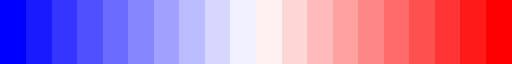

In [4]:
colormap=plt.cm.get_cmap("bwr", 20)

colormap

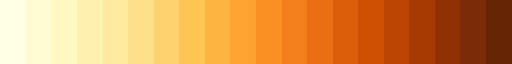

In [5]:
colormap=plt.cm.get_cmap("YlOrBr", 20)

colormap

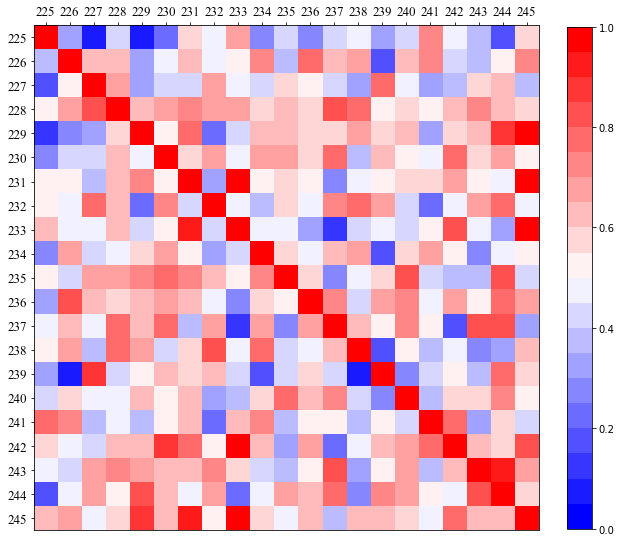

In [5]:
start=225
end=246
cor_matrix_sub=cor_matrix[start:end, start:end]

plt.figure(figsize=(10, 10))
plt.imshow(cor_matrix_sub, cmap=colormap, vmin=0, vmax=1)
plt.xticks(range(end-start), list(map(str, range(start, end))), fontproperties = "Times New Roman", size = 13)
plt.yticks(range(end-start), list(map(str, range(start, end))), fontproperties = "Times New Roman", size = 13)
plt.gca().xaxis.set_ticks_position("top")
plt.colorbar(fraction=0.045)
# plt.savefig("./images/heatmap_bwr.png", dpi=300, bbox_inches="tight")
plt.show();

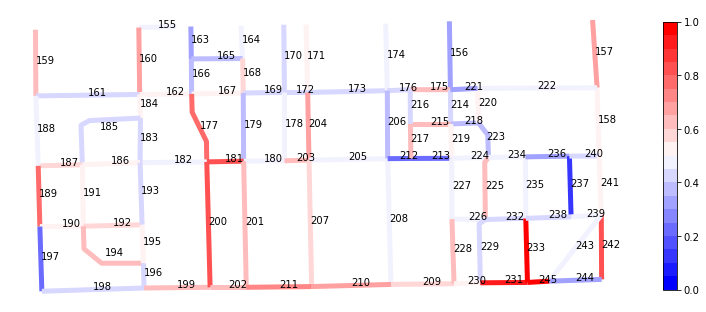

In [6]:
DATA_PATH = "../data/"
TAXI_DATA_PATH = "../data/taxi_after_proc/clean202006"
DATASET = "sz_taxi_202006"
df_edges = gpd.GeoDataFrame.from_file(os.path.join(DATA_PATH, DATASET, f"fmm_{DATASET}", "edges.shp"))

# color0=list(zip(cor_matrix[0], cor_matrix[0], cor_matrix[0], np.ones(len(cor_matrix[0]))))
# color0=list(zip(np.zeros(len(cor_matrix[0])), np.zeros(len(cor_matrix[0])), cor_matrix[0], np.ones(len(cor_matrix[0]))))
# color0=list(zip(np.zeros(len(cor_matrix[0])), np.zeros(len(cor_matrix[0])), cor_matrix[0], np.ones(len(cor_matrix[0]))))
# df_edges["color0"]=color0

def get_color(row):
    # val=-1+2*row.cor
    # if val>0:
    #     row["color"]=(val, 0, 0, 1)
    # else:
    #     row["color"]=(0, 0, -val, 1)
    
    # val=1-row.cor
    # row["color"]=(val, val, val, 1)
    
    row["color"]=colormap(row.cor)
        
    return row

n=233
df_edges["cor"]=cor_matrix[n]
df_edges=df_edges.apply(get_color, axis=1)
df_edges.at[n, "color"]=(1, 0, 0, 1)
if n<246:
    df_edges.at[n+246, "color"]=(1, 0, 0, 1)
else:
    df_edges.at[n-246, "color"]=(1, 0, 0, 1)

df_plot=df_edges[155:246]#.append(df_edges[155+246:246+246])

ax=df_plot.plot(color=df_plot.color, linewidth=5, figsize=(12, 8))
norm = plt.Normalize(vmin=0, vmax=1)
n_cmap = plt.cm.ScalarMappable(norm=norm, cmap=colormap)
n_cmap.set_array([])
ax.get_figure().colorbar(n_cmap, fraction=0.02)
ax.set_axis_off()
# ax.plot()

for index, row in df_plot.iterrows():
    x = row.geometry.centroid.x
    y = row.geometry.centroid.y
    plt.text(x, y, row.fid, fontsize=10, color="black")

# plt.savefig("./images/road_correlation_bwr.png", dpi=300, bbox_inches="tight")
plt.show();

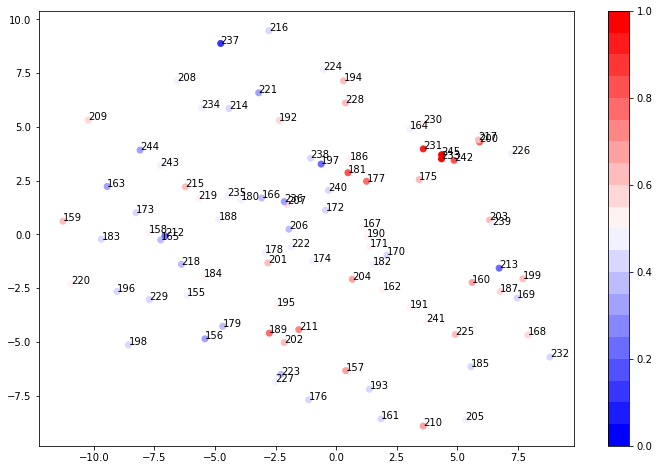

In [98]:
fig=plt.figure(figsize=(12, 8))
for i in range(len(tsne_res[155:246])):
    x=tsne_res[i+155][0]
    y=tsne_res[i+155][1]
    plt.text(x, y, i+155, fontsize=10, color="black")

plt.scatter(tsne_res[155:246][:, 0], tsne_res[155:246][:, 1], color=df_plot.color)
norm = plt.Normalize(vmin=0, vmax=1)
n_cmap = plt.cm.ScalarMappable(norm=norm, cmap=colormap)
n_cmap.set_array([])
fig.colorbar(n_cmap)
plt.savefig("./images/road_tsne.png", dpi=300, bbox_inches="tight")
plt.show();